In [ ]:
# import necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DataSet

In [ ]:
# load the dataset
!gdown https://drive.google.com/file/d/1whVJq5dtxSjvRPEF73fmWKYo-Yvp73_y/view?usp=share_link --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1whVJq5dtxSjvRPEF73fmWKYo-Yvp73_y
To: /content/A3_Dataset.zip
100% 126M/126M [00:01<00:00, 87.8MB/s]


In [ ]:
# unzip the data folder
!unzip /content/A3_Dataset.zip

In [ ]:
# save the train and test image and mask paths
TRAIN_IMAGE_PATH = '/content/A3_Dataset/dataset1/images_prepped_train'
TRAIN_MASK_PATH = '/content/A3_Dataset/dataset1/annotations_prepped_train'
TEST_IMAGE_PATH = '/content/A3_Dataset/dataset1/images_prepped_test'
TEST_MASK_PATH = '/content/A3_Dataset/dataset1/annotations_prepped_test'

In [ ]:
# a function to create a dataframe for the train and test set
n_classes = 12
def create_df(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [ ]:
# creating the dataframe
train_df = create_df(TRAIN_IMAGE_PATH)
test_df = create_df(TEST_IMAGE_PATH)

In [ ]:
# using the train dataframe to split the training data into train and validation using the ids
X_train, X_val = train_test_split(train_df['id'].values, test_size=0.2, random_state=19)
X_test = test_df['id'].values
print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  293
Val Size     :  74
Test Size    :  101


### Data Visualisation

In [ ]:
import matplotlib
print(matplotlib.rcParams['image.cmap'])

Image Size (360, 480, 3)
Mask Size (360, 480)


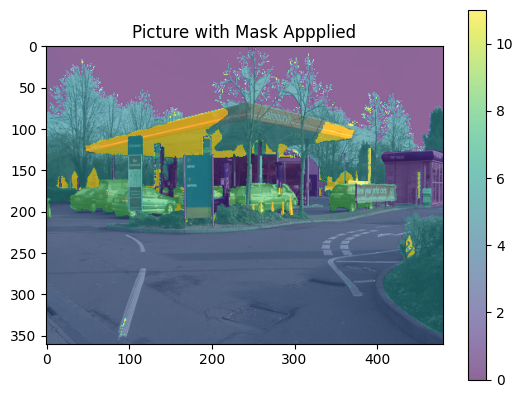

In [ ]:
# print one image with its mask applied to have an idea of the data set
img = Image.open(TRAIN_IMAGE_PATH + '/' + train_df['id'][100] + '.png')
mask = Image.open(TRAIN_MASK_PATH + '/' + train_df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img, cmap = 'viridis')
msk = plt.imshow(mask, alpha=0.6, cmap ='viridis')
plt.title('Picture with Mask Appplied')
#plt.show()

# Add a colorbar to show the mapping between colors and data values
plt.colorbar(msk)

# Show the plot
plt.show()

### Augmentation

The idea behind the augmentation applied is to apply greater number of augmentation tranformations to the images in the train set that contain high frequency of the classes that possess an overall low frequency in the dataset. This is to deal with the class imbalance.

Rest of the images in the train set and the complete test and validation set undergo the same basic transformations.

In [ ]:
# Find the percentage of each class in the train set

class_names = [0,1,2,3,4,5,6,7,8,9,10,11]
class_freq = {c: 0 for c in class_names}

for mask in os.listdir(TRAIN_MASK_PATH):
    mask = np.array(Image.open(os.path.join(TRAIN_MASK_PATH, mask)))
    
    for i, class_name in enumerate(class_names):
        class_freq[class_name] += np.sum(mask == i)

total_pixels = np.sum(list(class_freq.values()))
class_freq_perc = {c: (freq/total_pixels)*100 for c, freq in class_freq.items()}

print(class_freq_perc)

{0: 16.84511397466949, 1: 23.258652172267634, 2: 0.9829274523160764, 3: 31.658214754263803, 4: 4.486270372893329, 5: 9.724054521142396, 6: 1.1729535649409628, 7: 1.1268086461802402, 8: 5.86568555101423, 9: 0.6392310651932587, 10: 0.2916650898173378, 11: 3.9484228353012414}


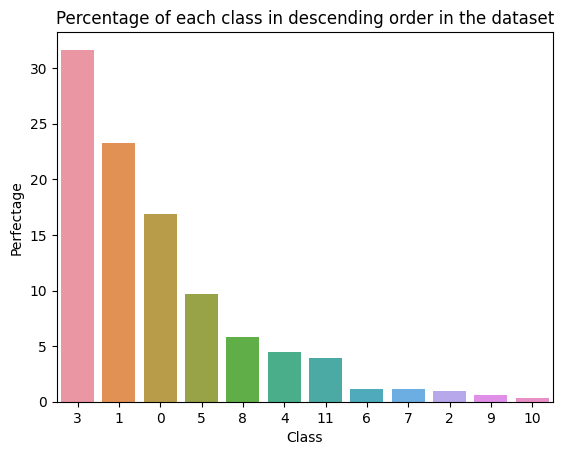

In [ ]:
# Visualise the frequencies of the classes

import seaborn as sns

sorted_items = sorted(class_freq_perc.items(), key=lambda item: item[1], reverse=True)
keys = [item[0] for item in sorted_items]
values = [item[1] for item in sorted_items]

sns.barplot(x=keys, y=values, order=keys)
plt.xlabel('Class')
plt.ylabel('Perfectage')
plt.title('Percentage of each class in descending order in the dataset')

plt.show()

In [ ]:
# Consider the classes with percentage less than 5 as low frequency classes
threshold = 5
low_freq_classes = [key for key, value in class_freq_perc.items() if value < threshold]
print(low_freq_classes)

[2, 4, 6, 7, 9, 10, 11]


In [ ]:
# define a class called conditionalaugmentation
# this class will first find the frequency of each class in each image
# then it will find the percentage of the low_freq_classes in the image
# if any of the low_freq_classes has percentage of greater than 10%, 
# then the image will be augmented using the traunsform_aug
# else simple transform is applied
# the trasnform_aug will have many augmentation transforms, while transform will be just basic resize and flip

class ConditionalAugmentation:
    def __init__(self, transform_aug, transform):
        self.transform_aug = transform_aug
        self.transform = transform
        
    def __call__(self, image, mask):

        freq_dict = {c: 0 for c in class_names}
        for i, class_name in enumerate(class_names):
            freq_dict[class_name] += np.sum(mask == i)
        total_pixels = np.sum(list(freq_dict.values()))
        freq_dict_perc = {c: (freq/total_pixels)*100 for c, freq in freq_dict.items()}

        low_freq = {k: v for k, v in freq_dict_perc.items() if k in low_freq_classes}

        # Apply augmentation only to low frequency classes
        if any(value > 10 for value in low_freq.values()):
            transformed = self.transform_aug(image=image, mask=mask)
        else:
            transformed = self.transform(image=image, mask=mask)
        
        return transformed

In [ ]:
# Define the augmentations
# These will be used later in the data loader 

t_train_aug = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), 
                     A.HorizontalFlip(), A.VerticalFlip(), 
                     A.RandomCrop(height=256, width=256),
                     A.RandomRotate90(),
                     A.GridDistortion(p=0.2),
                     A.OneOf([
                         A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
                         A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10),
                         A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10)
                     ]),
                     A.GaussNoise()
                     ])

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

t_test = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

### Data Loader

In [ ]:
# a class named Dataset to create a dataset which can be loaded to the data loader
# the will help join the images with their respective masks

class Dataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):

        img = cv2.imread(self.img_path + '/' +self.X[idx] + '.png')
        mask = cv2.imread(self.mask_path + '/' +self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [ ]:
# find the mean and standard deviation of the training data

mean = np.zeros(3)
std = np.zeros(3)

for filename in os.listdir(TRAIN_IMAGE_PATH):
    img = np.array(Image.open(os.path.join(TRAIN_IMAGE_PATH, filename)))
    mean += np.mean(img, axis=(0,1))
    std += np.std(img, axis=(0,1))

mean /= len(os.listdir(TRAIN_IMAGE_PATH)*255)
std /= len(os.listdir(TRAIN_IMAGE_PATH)*255)

print("Mean: ", mean)
print("Std: ", std)

Mean:  [0.41189488 0.4251328  0.43267069]
Std:  [0.2741347  0.28506175 0.28284592]


In [ ]:
# create the datasets and load on the data loader

# datasets
train_set = Dataset(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, X_train, mean, std, ConditionalAugmentation(t_train_aug, t_train))
val_set = Dataset(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, X_val, mean, std, t_val)
test_set = Dataset(TEST_IMAGE_PATH, TEST_MASK_PATH, X_test, mean, std, t_test)

#dataloader
batch_size= 8 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## Model

In [ ]:
# install and import the library
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.8 MB/s eta 0:00:00


In [ ]:
# load the model with MobileNet as the backbone
# use transfer learning with pretrained weights on imagenet
# the number of classes of our data is 12 and the encoder depth is set to be 5
unet_mobnet = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=12, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 228MB/s]


In [ ]:
unet_mobnet

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

## Training

In [ ]:
# Some helper functions when running the training loop

# Calculate pixel accuracy over a batch of images
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

# Calculate mean Intersection-over-Union over a batch of images
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=11):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
# Inner loop for running the model for 1 epoch over a given loader

def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)

    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = pixel_accuracy(output, labels)
  mean_IoU = mIoU(output, labels)

  return loss, accuracy, mean_IoU

### Training Configuration

In [ ]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss()

# Select an optimizer
optimizer = torch.optim.Adam(unet_mobnet.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Set the number of epochs
# This variable is used in the main training loop
epochs = 50

# save the model on the device
unet_mobnet.to(device);

If training from scratch

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

best_val_checkpoint_path = '/content/best_val_checkpoint.pth'

# Start epoch is zero for new training
start_epoch = 0

If training from Saved Checkpoint

In [ ]:
# Load the previous checkpoint
!gdown 'link' --fuzzy

In [ ]:
# Path to checkpoint
saved_checkpoint_path = 'path'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)

# Load all the state_dictionaries of the model, optimizer and schedular
unet_mobnet.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracies and losses for record keeping
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']
train_mIoUs = checkpoint['train_mIoUs']
val_mIoUs = checkpoint['val_mIoUs']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

# Load the value of the max val mIoU obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy
val_mIoU_max = checkpoint['val_accuracy_max']

### Main training loop

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch+1, current_lr))
  train_loss, train_accuracy, train_mIoU  = run_1_epoch(unet_mobnet, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_mIoUs.append(train_mIoU)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch+1))
  with torch.no_grad():
    val_loss, val_accuracy, val_mIoU  = run_1_epoch(unet_mobnet, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  val_mIoUs.append(val_mIoU)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  print('train_IoU %.2f'%(train_mIoU))
  print('val_IoU %.2f'%(val_mIoU))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_mIoU > val_mIoU_max:
    val_mIoU_max = val_mIoU
    print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

    checkpoint = {
    'model': unet_mobnet.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': unet_mobnet.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
  checkpoint_path = '/content/checkpoint_{}_{}.pth'.format(epoch, val_loss)

  torch.save(checkpoint, checkpoint_path)

Epoch 1: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 1.0850
val loss: 0.8458
train_accuracy 0.82
val_accuracy 0.78
train_IoU 0.32
val_IoU 0.29
New max val mean IoU Acheived 0.29. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.7738
val loss: 0.6284
train_accuracy 0.87
val_accuracy 0.87
train_IoU 0.41
val_IoU 0.38
New max val mean IoU Acheived 0.38. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.6412
val loss: 0.5954
train_accuracy 0.81
val_accuracy 0.90
train_IoU 0.36
val_IoU 0.40
New max val mean IoU Acheived 0.40. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.5885
val loss: 0.4951
train_accuracy 0.86
val_accuracy 0.90
train_IoU 0.38
val_IoU 0.44
New max val mean IoU Acheived 0.44. Saving model.


Epoch 5: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.5748
val loss: 0.4821
train_accuracy 0.82
val_accuracy 0.90
train_IoU 0.37
val_IoU 0.43
val mean IoU did not increase from 0.44


Epoch 6: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.5358
val loss: 0.4464
train_accuracy 0.73
val_accuracy 0.91
train_IoU 0.31
val_IoU 0.44
val mean IoU did not increase from 0.44


Epoch 7: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.5091
val loss: 0.4471
train_accuracy 0.83
val_accuracy 0.90
train_IoU 0.38
val_IoU 0.44
New max val mean IoU Acheived 0.44. Saving model.


Epoch 8: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4934
val loss: 0.4286
train_accuracy 0.86
val_accuracy 0.91
train_IoU 0.38
val_IoU 0.45
New max val mean IoU Acheived 0.45. Saving model.


Epoch 9: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4657
val loss: 0.4143
train_accuracy 0.86
val_accuracy 0.91
train_IoU 0.41
val_IoU 0.46
New max val mean IoU Acheived 0.46. Saving model.


Epoch 10: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 10: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4565
val loss: 0.4056
train_accuracy 0.83
val_accuracy 0.91
train_IoU 0.37
val_IoU 0.46
val mean IoU did not increase from 0.46


Epoch 11: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 11: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4500
val loss: 0.3844
train_accuracy 0.80
val_accuracy 0.91
train_IoU 0.41
val_IoU 0.46
val mean IoU did not increase from 0.46


Epoch 12: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 12: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4597
val loss: 0.4022
train_accuracy 0.81
val_accuracy 0.91
train_IoU 0.39
val_IoU 0.46
New max val mean IoU Acheived 0.46. Saving model.


Epoch 13: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 13: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4260
val loss: 0.3830
train_accuracy 0.89
val_accuracy 0.91
train_IoU 0.48
val_IoU 0.48
New max val mean IoU Acheived 0.48. Saving model.


Epoch 14: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 14: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3925
val loss: 0.3553
train_accuracy 0.89
val_accuracy 0.92
train_IoU 0.45
val_IoU 0.50
New max val mean IoU Acheived 0.50. Saving model.


Epoch 15: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 15: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3893
val loss: 0.3672
train_accuracy 0.87
val_accuracy 0.91
train_IoU 0.48
val_IoU 0.50
New max val mean IoU Acheived 0.50. Saving model.


Epoch 16: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 16: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3997
val loss: 0.3793
train_accuracy 0.85
val_accuracy 0.91
train_IoU 0.45
val_IoU 0.51
New max val mean IoU Acheived 0.51. Saving model.


Epoch 17: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 17: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3785
val loss: 0.3336
train_accuracy 0.90
val_accuracy 0.93
train_IoU 0.51
val_IoU 0.56
New max val mean IoU Acheived 0.56. Saving model.


Epoch 18: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 18: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3850
val loss: 0.4033
train_accuracy 0.90
val_accuracy 0.91
train_IoU 0.53
val_IoU 0.53
val mean IoU did not increase from 0.56


Epoch 19: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 19: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3725
val loss: 0.3764
train_accuracy 0.87
val_accuracy 0.92
train_IoU 0.48
val_IoU 0.51
val mean IoU did not increase from 0.56


Epoch 20: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 20: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3658
val loss: 0.3514
train_accuracy 0.90
val_accuracy 0.92
train_IoU 0.51
val_IoU 0.55
val mean IoU did not increase from 0.56


Epoch 21: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 21: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3635
val loss: 0.3230
train_accuracy 0.89
val_accuracy 0.93
train_IoU 0.53
val_IoU 0.58
New max val mean IoU Acheived 0.58. Saving model.


Epoch 22: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 22: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3630
val loss: 0.3368
train_accuracy 0.89
val_accuracy 0.92
train_IoU 0.57
val_IoU 0.55
val mean IoU did not increase from 0.58


Epoch 23: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 23: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3385
val loss: 0.3299
train_accuracy 0.92
val_accuracy 0.93
train_IoU 0.55
val_IoU 0.54
val mean IoU did not increase from 0.58


Epoch 24: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 24: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3326
val loss: 0.3249
train_accuracy 0.86
val_accuracy 0.91
train_IoU 0.57
val_IoU 0.56
val mean IoU did not increase from 0.58


Epoch 25: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 25: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3330
val loss: 0.3218
train_accuracy 0.90
val_accuracy 0.92
train_IoU 0.54
val_IoU 0.56
val mean IoU did not increase from 0.58


Epoch 26: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 26: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3377
val loss: 0.3505
train_accuracy 0.89
val_accuracy 0.91
train_IoU 0.53
val_IoU 0.54
val mean IoU did not increase from 0.58


Epoch 27: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 27: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3371
val loss: 0.3150
train_accuracy 0.87
val_accuracy 0.91
train_IoU 0.53
val_IoU 0.52
val mean IoU did not increase from 0.58


Epoch 28: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 28: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3190
val loss: 0.3142
train_accuracy 0.91
val_accuracy 0.93
train_IoU 0.56
val_IoU 0.59
New max val mean IoU Acheived 0.59. Saving model.


Epoch 29: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 29: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3022
val loss: 0.3125
train_accuracy 0.89
val_accuracy 0.93
train_IoU 0.58
val_IoU 0.59
val mean IoU did not increase from 0.59


Epoch 30: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 30: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3033
val loss: 0.3113
train_accuracy 0.92
val_accuracy 0.93
train_IoU 0.61
val_IoU 0.53
val mean IoU did not increase from 0.59


Epoch 31: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 31: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2856
val loss: 0.2880
train_accuracy 0.86
val_accuracy 0.93
train_IoU 0.51
val_IoU 0.56
val mean IoU did not increase from 0.59


Epoch 32: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 32: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2808
val loss: 0.2882
train_accuracy 0.90
val_accuracy 0.93
train_IoU 0.57
val_IoU 0.59
val mean IoU did not increase from 0.59


Epoch 33: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 33: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2736
val loss: 0.2874
train_accuracy 0.90
val_accuracy 0.92
train_IoU 0.51
val_IoU 0.59
val mean IoU did not increase from 0.59


Epoch 34: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 34: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2660
val loss: 0.2832
train_accuracy 0.92
val_accuracy 0.94
train_IoU 0.63
val_IoU 0.59
val mean IoU did not increase from 0.59


Epoch 35: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 35: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2656
val loss: 0.2840
train_accuracy 0.92
val_accuracy 0.94
train_IoU 0.56
val_IoU 0.59
New max val mean IoU Acheived 0.59. Saving model.


Epoch 36: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 36: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2612
val loss: 0.2745
train_accuracy 0.90
val_accuracy 0.94
train_IoU 0.56
val_IoU 0.60
New max val mean IoU Acheived 0.60. Saving model.


Epoch 37: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 37: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2626
val loss: 0.2774
train_accuracy 0.91
val_accuracy 0.94
train_IoU 0.61
val_IoU 0.59
val mean IoU did not increase from 0.60


Epoch 38: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 38: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2613
val loss: 0.2783
train_accuracy 0.89
val_accuracy 0.94
train_IoU 0.59
val_IoU 0.62
New max val mean IoU Acheived 0.62. Saving model.


Epoch 39: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 39: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2595
val loss: 0.2793
train_accuracy 0.90
val_accuracy 0.94
train_IoU 0.59
val_IoU 0.59
val mean IoU did not increase from 0.62


Epoch 40: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 40: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2614
val loss: 0.2762
train_accuracy 0.92
val_accuracy 0.94
train_IoU 0.62
val_IoU 0.61
val mean IoU did not increase from 0.62


Epoch 41: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 41: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2582
val loss: 0.2762
train_accuracy 0.92
val_accuracy 0.94
train_IoU 0.58
val_IoU 0.55
val mean IoU did not increase from 0.62


Epoch 42: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 42: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2583
val loss: 0.2825
train_accuracy 0.92
val_accuracy 0.94
train_IoU 0.66
val_IoU 0.61
val mean IoU did not increase from 0.62


Epoch 43: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 43: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2555
val loss: 0.2731
train_accuracy 0.93
val_accuracy 0.94
train_IoU 0.56
val_IoU 0.59
val mean IoU did not increase from 0.62


Epoch 44: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 44: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2553
val loss: 0.2800
train_accuracy 0.94
val_accuracy 0.93
train_IoU 0.60
val_IoU 0.57
val mean IoU did not increase from 0.62


Epoch 45: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 45: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2514
val loss: 0.2674
train_accuracy 0.93
val_accuracy 0.94
train_IoU 0.59
val_IoU 0.60
val mean IoU did not increase from 0.62


Epoch 46: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 46: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2534
val loss: 0.2739
train_accuracy 0.90
val_accuracy 0.94
train_IoU 0.55
val_IoU 0.62
val mean IoU did not increase from 0.62


Epoch 47: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 47: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2494
val loss: 0.2733
train_accuracy 0.92
val_accuracy 0.94
train_IoU 0.60
val_IoU 0.61
val mean IoU did not increase from 0.62


Epoch 48: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 48: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2532
val loss: 0.2705
train_accuracy 0.93
val_accuracy 0.94
train_IoU 0.60
val_IoU 0.61
val mean IoU did not increase from 0.62


Epoch 49: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 49: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2470
val loss: 0.2721
train_accuracy 0.93
val_accuracy 0.94
train_IoU 0.61
val_IoU 0.53
val mean IoU did not increase from 0.62


Epoch 50: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 50: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2508
val loss: 0.2673
train_accuracy 0.93
val_accuracy 0.94
train_IoU 0.60
val_IoU 0.61
val mean IoU did not increase from 0.62




Text(0.5, 1.0, 'Training and val mIoU')

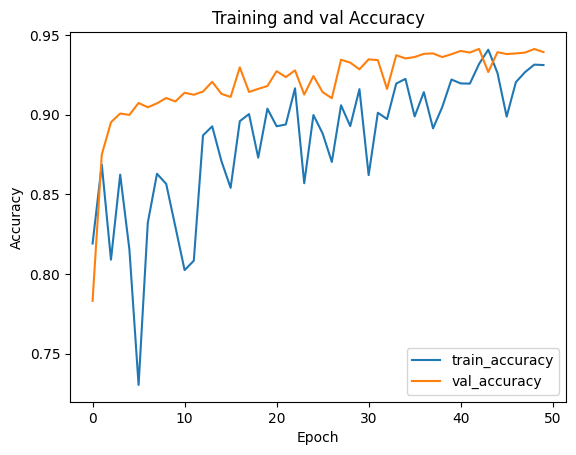

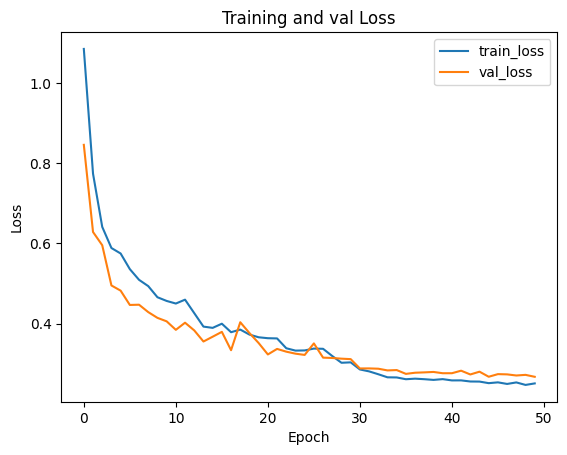

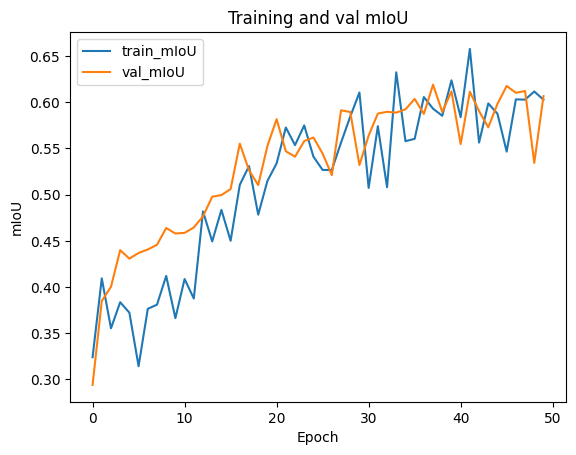

In [ ]:
# Training Graphs

plt.figure()
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(val_accuracies, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

plt.figure()
plt.plot(train_mIoUs, label="train_mIoU")
plt.plot(val_mIoUs, label="val_mIoU")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and val mIoU')

## Testing

In [ ]:
# download the model
!gdown 'https://drive.google.com/file/d/1SyIIyyy4kvdYYfJa1zuDu_97RDcgV4Kh/view?usp=share_link' --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1_131z7EN6woKDKwbZMcCO6ExivsatMYj
To: /content/best_val_checkpoint.pth
100% 80.0M/80.0M [00:00<00:00, 190MB/s]


In [ ]:
# load the model
best_val_model_path = '/content/best_val_checkpoint.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
unet_mobnet.load_state_dict(best_val_checkpoint['model'])

<All keys matched successfully>

In [ ]:
# Define a function for one epoch on the testing images
# Testing images run on one epoch only
def run_1_epoch_test(model, loss_fn, loader, optimizer = None, display= False):
  model.eval()

  # some helping variables 

  total_correct_preds = 0
  total_loss = 0
  all_labels = []
  all_preds = []
  all_outputs = []
  imgs = []

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Forward pass on the input batch
    output = model(image_batch)

    masked = torch.argmax(output, dim=1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)

    total_loss += loss.item()

    # Append the labels and predictions to the list
    all_labels.append(labels.cpu())
    all_preds.append(masked.cpu())
    all_outputs.append(output.cpu())
    if display:
      imgs.append(image_batch.cpu())

  # Concatenate all the labels and predictions along the batch dimension
  all_labels = torch.cat(all_labels, dim=0)
  all_preds = torch.cat(all_preds, dim=0)
  all_outputs = torch.cat(all_outputs, dim=0)
  if display: 
    imgs = torch.cat(imgs, dim=0)

  loss = total_loss / total_batches_in_loader
  accuracy = pixel_accuracy(all_outputs, all_labels)
  mean_IoU = mIoU(all_outputs, all_labels)

  #if display is true then the images are also returned
  if display:
    return imgs, all_labels, all_preds, loss, accuracy, mean_IoU
  else:
    return all_labels, all_preds, loss, accuracy, mean_IoU

In [ ]:
# Test the model on the test loader
with torch.no_grad():
    test_labels, test_preds, test_loss, test_accuracy, test_mIoU  = run_1_epoch_test(unet_mobnet, loss_function, test_loader)

  0%|          | 0/13 [00:00<?, ?it/s]

### Evaluation Metrics

In [ ]:
print('Test Loss: ' ,test_loss)
print('Test Accuracy: ',test_accuracy)
print('Test mean Intersection over Union: ',test_mIoU)

Test Loss:  0.27852345888431257
Test Accuracy:  0.9098929225808323
Test mean Intersection over Union:  0.611851511213028


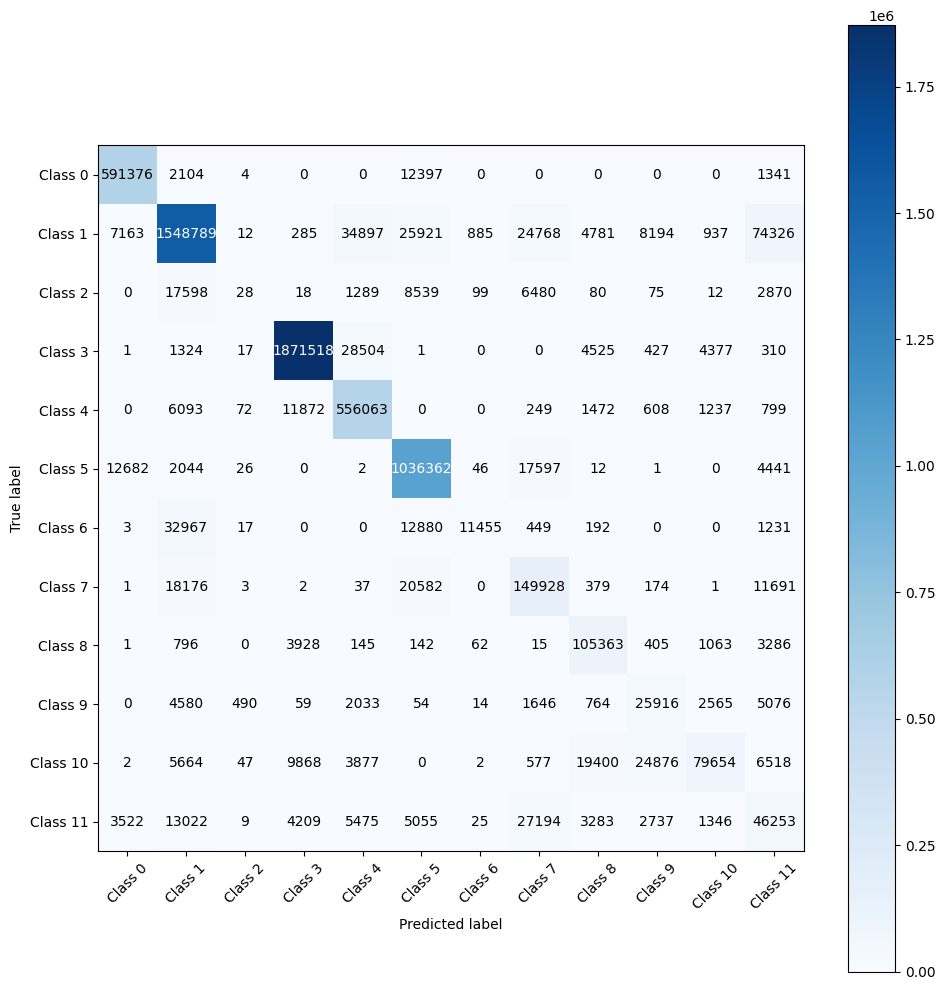

In [ ]:
# calculate confusion matrix
conf_mat = confusion_matrix(test_labels.cpu().flatten(), test_preds.cpu().flatten())

# plot confusion matrix as a figure
plt.figure(figsize=(10, 10))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.colorbar()

# add axis labels
tick_marks = np.arange(12)
plt.xticks(tick_marks, [f'Class {i}' for i in range(12)], rotation=45)
plt.yticks(tick_marks, [f'Class {i}' for i in range(12)])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# add text annotations in each cell
thresh = conf_mat.max() / 2.
for i in range(12):
    for j in range(12):
        plt.text(j, i, f'{conf_mat[i, j]}', ha='center', va='center', 
                 color='white' if conf_mat[i, j] > thresh else 'black')
        
plt.tight_layout()
plt.show()

In [ ]:
# Dice score, specificity and sensitivity is calculated from the confusion matrix for each class
dice_scores = []
specificity_scores = []
sensitivity_scores = []
for i in range(12):
    tp = conf_mat[i,i]
    fp = conf_mat[:,i].sum() - tp
    tn = np.sum(np.delete(np.delete(conf_mat, i, 0), i, 1))
    fn = conf_mat[i,:].sum() - tp
    dice = (2 * tp) / (2 * tp + fp + fn)
    dice_scores.append(dice)
    specificities = tn / (tn + fp)
    specificity_scores.append(specificities)
    sensitivities = tp / (tp + fn)
    sensitivity_scores.append(sensitivities)

data = {'Dice': dice_scores, 'Sensitivity': sensitivity_scores, 'Specificity': specificity_scores}
df = pd.DataFrame(data)

# Display DataFrame
print(df)

        Dice  Sensitivity  Specificity
0   0.967904     0.973904     0.996112
1   0.915329     0.894758     0.978649
2   0.001481     0.000755     0.999894
3   0.981712     0.979338     0.993577
4   0.918515     0.961273     0.987376
5   0.944231     0.965663     0.984570
6   0.319161     0.193516     0.999827
7   0.697539     0.746007     0.987695
8   0.824898     0.914562     0.994636
9   0.486183     0.599949     0.994298
10  0.659177     0.529315     0.998216
11  0.342270     0.412494     0.982805


In [ ]:
# Classification Report 

# Flatten the labels and predictions
y_true = test_labels.cpu().flatten()
y_pred = test_preds.cpu().flatten()

# Generate the classification report
report = classification_report(y_true, y_pred, labels=range(12))

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97    607222
           1       0.94      0.89      0.92   1730958
           2       0.04      0.00      0.00     37088
           3       0.98      0.98      0.98   1911004
           4       0.88      0.96      0.92    578465
           5       0.92      0.97      0.94   1073213
           6       0.91      0.19      0.32     59194
           7       0.65      0.75      0.70    200974
           8       0.75      0.91      0.82    115206
           9       0.41      0.60      0.49     43197
          10       0.87      0.53      0.66    150485
          11       0.29      0.41      0.34    112130

    accuracy                           0.91   6619136
   macro avg       0.72      0.68      0.67   6619136
weighted avg       0.91      0.91      0.91   6619136



### Some images with their actual and predicted segmentation maps

In [ ]:
# choose a subset of images from the test images
X_dis = test_df['id'].values[[2,33,70]]
dis_set = Dataset(TEST_IMAGE_PATH, TEST_MASK_PATH, X_dis, mean, std, t_test)
dis_loader = DataLoader(dis_set, batch_size=1, shuffle=False)

In [ ]:
# Run the model on the images
with torch.no_grad():
    imgs, labels, masked, loss, accuracy, mean_IoU = run_1_epoch_test(unet_mobnet, loss_function, dis_loader, display=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Convert the labels and masked tensors to numpy arrays
imgs = imgs.numpy().squeeze()
labels = labels.cpu().numpy().squeeze()
masked = masked.cpu().numpy().squeeze()

# Define the color map for the masks
cmap = plt.get_cmap('tab20')

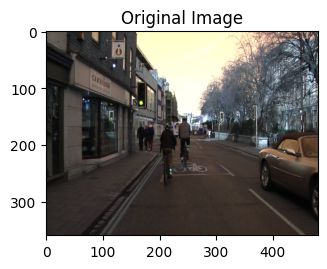

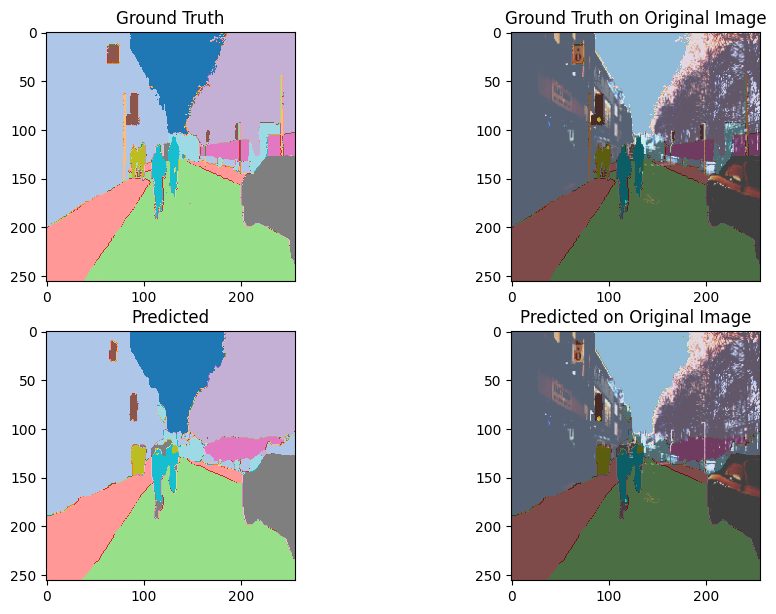

In [ ]:
o_img = cv2.imread(TEST_IMAGE_PATH+ '/' + X_dis[1] + '.png')
img = np.transpose(imgs[1], (1, 2, 0))

plt.figure(figsize=(9, 9))
# Plthe original image
plt.subplot(3 ,2 ,1)
plt.imshow(o_img)
plt.title('Original Image')

plt.figure(figsize=(11, 11))
# Plot the ground truth mask
plt.subplot(3, 2, 3)
plt.imshow(labels[1], cmap=cmap)
plt.title('Ground Truth')

# Plot the ground truth mask superimposed on the original image
plt.subplot(3, 2, 4)
plt.imshow(img)
plt.imshow(labels[1], cmap=cmap, alpha=0.5)
plt.title('Ground Truth on Original Image')

# Plot the predicted mask
plt.subplot(3, 2, 5)
plt.imshow(masked[1], cmap=cmap)
plt.title('Predicted')

# Plot the predicted mask superimposed on the original image
plt.subplot(3, 2, 6)
plt.imshow(img)
plt.imshow(masked[1], cmap=cmap, alpha=0.5)
plt.title('Predicted on Original Image')

plt.show()

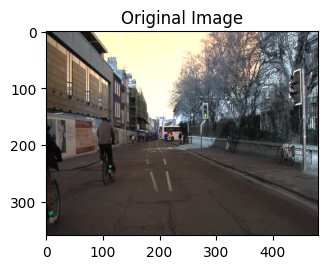

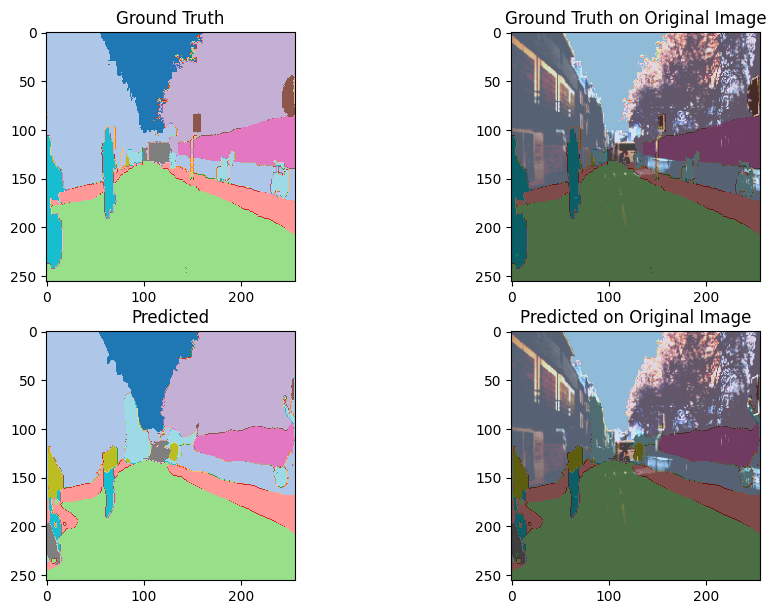

In [ ]:
o_img = cv2.imread(TEST_IMAGE_PATH+ '/' + X_dis[2] + '.png')
img = np.transpose(imgs[2], (1, 2, 0))

plt.figure(figsize=(9, 9))
# Plot the original image
plt.subplot(3, 2, 1)
plt.imshow(o_img)
plt.title('Original Image')

plt.figure(figsize=(11, 11))
# Plot the ground truth mask
plt.subplot(3, 2, 3)
plt.imshow(labels[2], cmap=cmap)
plt.title('Ground Truth')

# Plot the ground truth mask superimposed on the original image
plt.subplot(3, 2, 4)
plt.imshow(img)
plt.imshow(labels[2], cmap=cmap, alpha=0.5)
plt.title('Ground Truth on Original Image')

# Plot the predicted mask
plt.subplot(3, 2, 5)
plt.imshow(masked[2], cmap=cmap)
plt.title('Predicted')

# Plot the predicted mask superimposed on the original image
plt.subplot(3, 2, 6)
plt.imshow(img)
plt.imshow(masked[2], cmap=cmap, alpha=0.5)
plt.title('Predicted on Original Image')

plt.show()